### ESBM for recommender systems

LAST FULL FUN 23/04 9:20

In [892]:
#!uv pip install -q --system numba-cuda==0.4.0

In [893]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
from collections import OrderedDict
from scipy.special import gamma
import scipy.special as sc
import numba as nb
from scipy.special import gammaln
import time
import seaborn as sns
from math import lgamma
from numba import cuda
from scipy.stats import mode
from functs import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from numba import njit

In [894]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows")

In [895]:
# from numba import config
# config.CUDA_ENABLE_PYNVJITLINK = 1

In [ ]:
import numpy as np
from numba import njit # Cleaner import
from math import lgamma # Numba supports math.lgamma directly
# Note: If you used scipy.special.gammaln previously, use math.lgamma for nopython mode

# @njit(nopython=True) # Using @njit alias
@nb.jit(nopython=True) # Or stick to your original style
def sampling_scheme_opt(V: int, 
                      H_current_active: int, # Renamed for clarity (this is H_for_prob_calc)
                      frequencies_active: np.ndarray, # The active part of frequencies
                      bar_h: int, 
                      scheme_type: str, 
                      scheme_param: float, 
                      sigma: float, 
                      gamma: float):
    """
    Calculates sampling scheme probabilities for H_current_active existing clusters
    and 1 new cluster.
    Returns an array of size H_current_active + 1.
    """
    num_options = H_current_active + 1
    probs = np.zeros(num_options, dtype=np.float64) # Use float64 for probabilities

    # --- Dirichlet Process (DP) ---
    if scheme_type == 'DP':
        # Existing clusters: prob proportional to frequency
        for i in range(H_current_active):
            probs[i] = frequencies_active[i]
        # New cluster: prob proportional to scheme_param (alpha)
        probs[H_current_active] = scheme_param
    
    # --- Pitman-Yor (PY) ---
    elif scheme_type == 'PY':
         # Existing clusters: prob proportional to frequency - sigma
        for i in range(H_current_active):
            # Ensure non-negative probability contribution (though normalization handles it)
            probs[i] = max(0.0, frequencies_active[i] - sigma) 
        # New cluster: prob proportional to scheme_param + H_current_active * sigma
        probs[H_current_active] = scheme_param + H_current_active * sigma

    # --- Dirichlet Multinomial (DM) like - based on original logic ---
    # Note: The check H < bar_h might ideally use the H *before* removing the user.
    # Here we use H_current_active, which is H after potential emptying. Adjust if needed.
    elif scheme_type == 'DM':
        if H_current_active < bar_h:
            # Existing clusters: prob proportional to frequency - sigma
            for i in range(H_current_active):
                 probs[i] = max(0.0, frequencies_active[i] - sigma)
            # New cluster: proportional to remaining "tables" up to bar_h
            # Original code had -sigma*(bar_h-H). Need clarification if this should be positive for prob.
            # Assuming it should represent a positive mass for new clusters:
            probs[H_current_active] = max(0.0, sigma * (bar_h - H_current_active))
            # If H_current_active >= bar_h, the new cluster prob contribution from this term is 0
        else: # H_current_active >= bar_h
             # Only existing clusters get mass based on frequency - sigma
            for i in range(H_current_active):
                probs[i] = max(0.0, frequencies_active[i] - sigma)
            # probs[H_current_active] remains 0 (no new cluster mass from this scheme part)
            # This case needs careful review - does DM truly assign 0 probability to new clusters if H >= bar_h?
            # Often, there's still a base rate (like alpha in DP/PY). If so, combine schemes.
            # If scheme_param represents a base rate, it should be added here.
            # For now, sticking to the literal translation of the original snippet.

    # --- Generalized Negative Binomial (GN?) - interpretation based on original ---
    # This looks unusual for a cluster sampling scheme prior. Verify the formula.
    # Assuming it's meant to be proportional to these values.
    elif scheme_type == 'GN':
        for i in range(H_current_active):
            # Ensure base is non-negative if it represents counts/frequencies
            probs[i] = max(0.0, frequencies_active[i] + 1.0) * max(0.0, V - H_current_active + gamma) 
        probs[H_current_active] = max(0.0, H_current_active * (H_current_active - gamma))

    # --- Fallback/Error for unknown scheme ---
    else:
        # Handle unknown scheme type - e.g., raise error or default to uniform/DP
        # Numba requires all paths to be typed, so raising errors can be tricky.
        # Defaulting to DP might be safer in a JIT context if errors aren't easy.
        # For now, assume valid scheme_type is passed.
        # If defaulting:
        # for i in range(H_current_active):
        #     probs[i] = frequencies_active[i]
        # probs[H_current_active] = 1.0 # Default alpha = 1.0
        pass # Assuming valid input

    # --- Normalize probabilities ---
    probs_sum = np.sum(probs)
    if probs_sum > 1e-9: # Avoid division by zero/NaN
        probs /= probs_sum
    else:
        # If sum is zero (e.g., H=0, scheme_param=0), assign uniform probability
        if num_options > 0:
            probs[:] = 1.0 / num_options
        # If num_options is 0 (H_current_active is -1?), something is wrong upstream.
        # Numba might require an explicit handling/error for num_options=0 case.

    return probs


# @njit(nopython=True, fastmath=True)
@nb.jit(nopython=True, fastmath=True) # Stick to original style
def compute_prob_cpu_unif_opt(mhk_calc: np.ndarray, # Renamed from mhk_minus
                          frequencies_primary_calc: np.ndarray, # Renamed
                          frequencies_secondary: np.ndarray,
                          y_values: np.ndarray, # Should be contiguous (ensured by caller)
                          epsilon: float, 
                          a: float, 
                          b: float, 
                          # max_clusters removed - derived from mhk_calc
                          degree_corrected: bool,
                          degree_cluster_calc: np.ndarray, # Renamed
                          degree_node: float, # Single value for the current node u
                          degree_param: float, 
                          is_user_mode: bool):
    """
    Computes log-likelihood contributions for assigning the node to existing clusters 
    or a new cluster.
    Returns an array of log-probabilities of size H_calc + 1.
    """
    H_calc = mhk_calc.shape[0] # Number of existing clusters to evaluate
    num_secondary_entities = len(frequencies_secondary) # e.g., V (number of item clusters)
    num_options = H_calc + 1
    
    log_probs = np.zeros(num_options, dtype=np.float64)

    # Pre-calculate constants outside loops
    a_plus_epsilon = a + epsilon
    lgamma_a = lgamma(a)
    log_b = np.log(b + epsilon) # Add epsilon for safety if b can be 0
    lgamma_a_log_b = -lgamma_a + a * log_b # Used for new cluster calculation

    # --- Log-likelihood for existing clusters ---
    for i in range(H_calc): # Iterate over existing clusters 0 to H_calc-1
        p_i_lik = 0.0 # Log-likelihood contribution from counts/interactions
        freq_prim_i = frequencies_primary_calc[i]
        
        # Inner loop over secondary entities (e.g., item clusters)
        for j in range(num_secondary_entities):
            # Determine indices based on mode
            # In user mode (is_user_mode=True):
            # i = user cluster index (h), j = item cluster index (k)
            # mhk_calc[i, j] is interaction count between user cluster i and item cluster j
            # y_values[j] is the interaction of the current user u with item cluster j
            # freq_prim_i is count of users in user cluster i
            # frequencies_secondary[j] is count of items in item cluster j
            
            # In item mode (is_user_mode=False):
            # i = item cluster index (k), j = user cluster index (h)
            # mhk_calc[i, j] is interaction count between user cluster j and item cluster i (Note index order!)
            # y_values[j] is the interaction of the current item v with user cluster j
            # freq_prim_i is count of items in item cluster i
            # frequencies_secondary[j] is count of users in user cluster j

            # The original code had `h, k = i, j` or `k, h = i, j`. Let's map directly:
            if is_user_mode:
                mhk_val = mhk_calc[i, j]
                y_val = y_values[j]
                freq_sec_j = frequencies_secondary[j]
            else: # Item mode - assumes mhk_calc[k_idx, h_idx] structure needed
                # We need mhk[h, k] where k=i (current item cluster), h=j (user cluster)
                # So we access mhk_calc[i, j] *IF* mhk_calc is passed with shape (num_item_clusters, num_user_clusters)
                # This indicates the *caller* needs to prepare mhk_calc correctly depending on mode.
                # Assuming the caller handles it and mhk_calc[i,j] gives the right value:
                mhk_val = mhk_calc[i, j] 
                y_val = y_values[j] # Interaction of item 'v' with user cluster 'j'
                freq_sec_j = frequencies_secondary[j] # Freq of user cluster 'j'
            
            mhk_plus_a = mhk_val + a_plus_epsilon
            mhk_plus_y_plus_a = mhk_val + y_val + a_plus_epsilon
            
            # Add epsilon inside log for safety
            log_freq_prod1 = np.log(b + freq_prim_i * freq_sec_j + epsilon) 
            log_freq_prod2 = np.log(b + (freq_prim_i + 1.0) * freq_sec_j + epsilon)
            
            p_i_lik += (lgamma(mhk_plus_y_plus_a) - lgamma(mhk_plus_a) +
                       (mhk_plus_a - epsilon) * log_freq_prod1 -
                       (mhk_plus_y_plus_a - epsilon) * log_freq_prod2)
            
        log_probs[i] = p_i_lik # Assign likelihood part
        
        # --- Add Degree Correction term for existing clusters ---
        if degree_corrected:
            deg_clust_i = degree_cluster_calc[i]
            # Add epsilon inside logs and potentially to denominators of lgamma for stability
            # Note: Original formula had terms like lgamma(freq*param + deg). Ensure freq*param is not problematic.
            
            # Using max(..., epsilon) to avoid log(0) or lgamma(<=0) if counts can be 0
            term1_num = lgamma(max(epsilon, freq_prim_i * degree_param + deg_clust_i))
            term1_den = lgamma(max(epsilon, (freq_prim_i + 1.0) * degree_param + deg_clust_i + degree_node))
            
            term2_num = lgamma(max(epsilon, (freq_prim_i + 1.0) * degree_param))
            term2_den = lgamma(max(epsilon, freq_prim_i * degree_param))
            
            # Log terms need careful handling if frequencies are zero
            term3_num_log = (deg_clust_i + degree_node) * np.log(max(epsilon, freq_prim_i + 1.0))
            term3_den_log = deg_clust_i * np.log(max(epsilon, freq_prim_i))
            
            log_probs[i] += (term1_num - term1_den + 
                             term2_num - term2_den + 
                             term3_num_log - term3_den_log)

    # --- Log-likelihood for a NEW cluster ---
    # Index for the new cluster is H_calc
    p_new_lik = 0.0
    for j in range(num_secondary_entities):
        y_val = y_values[j]
        if is_user_mode:
            freq_sec_j = frequencies_secondary[j]
        else: # Item mode
            freq_sec_j = frequencies_secondary[j] # Freq of user cluster 'j'
        
        p_new_lik += (lgamma(y_val + a_plus_epsilon) + lgamma_a_log_b -
                      (y_val + a) * np.log(b + freq_sec_j + epsilon)) # Added epsilon

    log_probs[H_calc] = p_new_lik # Assign likelihood part

    # --- Add Degree Correction term for the NEW cluster ---
    if degree_corrected:
        # For a new cluster: freq_primary = 0, degree_cluster = 0
        # The formula simplifies significantly. Check the derivation for the correct form.
        # Original code had: lgamma(degree_param) - lgamma(degree_param+degree_node)
        # This seems plausible, representing the change from an empty cluster state.
        log_probs[H_calc] += (lgamma(max(epsilon, degree_param)) - 
                              lgamma(max(epsilon, degree_param + degree_node)))

    return log_probs

@nb.jit(nopython=True, fastmath=True, parallel=False) # Your original decorator
def gibbs_step_users_optimized(
    user_clustering: np.ndarray,
    num_users: int,
    frequencies_users: np.ndarray, # Pre-allocated to max_H_users
    frequencies_items: np.ndarray,
    degree_param_users: float, # Changed to float as it's often a variance/precision
    mhk: np.ndarray, # 2D array, pre-allocated to (max_H_users, V)
    yuk: np.ndarray,
    H: int, # Current number of active user clusters
    V: int,
    K:int,
    bar_h_users: int,
    scheme_type: str,
    scheme_param_users: float,
    sigma: float,
    gamma: float,
    prior_a: float, # Changed to float for more flexibility
    prior_b: float, # Changed to float
    degree_cluster_users: np.ndarray, # Pre-allocated to max_H_users
    rng: np.random.Generator, # Use NumPy's new Generator
    degree_users: np.ndarray,
    verbose_users=False,
    epsilon=1e-10
):
    max_H_users = num_users
    order_users = np.arange(num_users)
    #rng.shuffle(order_users)
    for u_idx in order_users:
        # if verbose_users is True:
        #     print('\n', user_clustering, u_idx)
        #     print('H ', H)
        #     print('frequencies', frequencies_users)
        #     print('cluster degree', degree_cluster_users)

        current_cluster_idx = user_clustering[u_idx]
        yuk_u = yuk[u_idx]
        sum_yuk_u = np.sum(yuk_u)

        # --- Step 1: Temporarily remove user u_idx from its current cluster ---
        # These modifications are to the main arrays, but will be adjusted based on new assignment.
        frequencies_users[current_cluster_idx] -= 1
        mhk[current_cluster_idx] -= yuk_u
        degree_cluster_users[current_cluster_idx] -= sum_yuk_u
        
        H_for_prob_calc = H
        cluster_emptied = (frequencies_users[current_cluster_idx] == 0)

        # --- Step 2: Prepare data for probability calculation ---
        # These are temporary arrays/views for calculating probabilities
        if cluster_emptied:
            # If the cluster became empty, we calculate probabilities over H-1 existing clusters + 1 new
            H_for_prob_calc = H - 1
            
            # Frequencies for probability calculation (excluding the emptied one)
            # Needs to be a new array if we are removing an element
            frequencies_users_prob_calc = np.empty(H_for_prob_calc, dtype=frequencies_users.dtype)
            mhk_prob_calc = np.empty((H_for_prob_calc, K), dtype=mhk.dtype)
            degree_cluster_users_prob_calc = np.empty(H_for_prob_calc, dtype=degree_cluster_users.dtype)
            
            target_idx = 0
            for k_old in range(H):
                if k_old != current_cluster_idx:
                    frequencies_users_prob_calc[target_idx] = frequencies_users[k_old]
                    mhk_prob_calc[target_idx] = mhk[k_old] # mhk[k_old] is already updated if k_old was current_cluster_idx
                    degree_cluster_users_prob_calc[target_idx] = degree_cluster_users[k_old]
                    target_idx += 1
        else:
            # Cluster not emptied, calculate probabilities over H existing clusters + 1 new
            # We can use views of the active parts of the main arrays
            frequencies_users_prob_calc = frequencies_users[:H] 
            mhk_prob_calc = mhk[:H] 
            degree_cluster_users_prob_calc = degree_cluster_users[:H]

        # --- Step 3: Calculate probabilities ---
        # scheme_probs has H_for_prob_calc + 1 elements
        scheme_probs = sampling_scheme_opt(V, H_for_prob_calc, 
                                       frequencies_users_prob_calc, # Pass the potentially smaller array
                                       bar_h_users, scheme_type,
                                       scheme_param_users, sigma, gamma)

        # log_likelihoods also has H_for_prob_calc + 1 elements
        log_likelihoods = compute_prob_cpu_unif_opt(
                                    mhk_calc=mhk_prob_calc, 
                                    frequencies_primary_calc=frequencies_users_prob_calc,
                                    frequencies_secondary=frequencies_items, 
                                    y_values=np.ascontiguousarray(yuk_u), # Ensure contiguous
                                    epsilon=epsilon, 
                                    a = prior_a, 
                                    b=prior_b, 
                                    degree_corrected=True, # degree_corrected
                                    degree_cluster_calc=degree_cluster_users_prob_calc, 
                                    degree_node=degree_users[u_idx], 
                                    degree_param=degree_param_users,
                                    is_user_mode=True) # is_user_mode
        
        # Combine and normalize probabilities
        # Ensure scheme_probs and log_likelihoods have same length: H_for_prob_calc + 1
        if len(scheme_probs) != len(log_likelihoods):
             # This indicates a mismatch in logic or placeholder implementation
             raise ValueError(f"Probabilities length mismatch: scheme={len(scheme_probs)}, ll={len(log_likelihoods)}")

        # Log-domain addition, then exponentiation with stability (LogSumExp)
        # Add epsilon to scheme_probs before log to avoid log(0)
        probs_unnorm_log = np.log(scheme_probs + epsilon) + log_likelihoods
        
        # Subtract max for numerical stability before exp
        max_log_prob = np.max(probs_unnorm_log)
        probs_exp = np.exp(probs_unnorm_log - max_log_prob)
        probs_sum = np.sum(probs_exp)
        if probs_sum > epsilon: # Avoid division by zero if all probs are tiny
            probs_norm = probs_exp / probs_sum
        else: # Fallback: uniform if sum is too small
            num_options = len(probs_unnorm_log)
            probs_norm = np.ones(num_options) / num_options


        # --- Step 4: Choose new cluster assignment ---
        # `assigned_calc_idx` is an index into the `probs_norm` array (0 to H_for_prob_calc)
        # num_candidates = len(probs_norm)
        
        # assigned_calc_idx = rng.choice(num_candidates, p=probs_norm)
        rand = rng.random()
        cumm_p = 0.0
        for candidate in range(len(probs_norm)):
            cumm_p += probs_norm[candidate]
            if rand <= cumm_p:
                assigned_calc_idx = candidate
                break
        #print(u_idx, probs_norm)

        # --- Step 5: Update main arrays based on new assignment ---
        
        newly_assigned_cluster_true_idx = -1 # Placeholder for the actual index in main arrays

        # Case A: User is assigned to one of the existing clusters (in the context of prob_calc arrays)
        if assigned_calc_idx < H_for_prob_calc:
            # if verbose_users is True:
            #     print('old cluster ', assigned_calc_idx)
            if cluster_emptied:
                # Map index from prob_calc space (which excluded current_cluster_idx) back to true index space
                # Find the true index corresponding to assigned_calc_idx
                # This requires careful mapping if current_cluster_idx was "in the middle"
                # If current_cluster_idx was 0, then true index is assigned_calc_idx + 1
                # If current_cluster_idx was k, then true index is assigned_calc_idx if assigned_calc_idx < k, else assigned_calc_idx + 1
                # Simpler to iterate and find:
                temp_idx_count = 0
                for k_old in range(H): # Iterate up to original H
                    if k_old != current_cluster_idx:
                        if temp_idx_count == assigned_calc_idx:
                            newly_assigned_cluster_true_idx = k_old
                            break
                        temp_idx_count += 1
            else: # Cluster was not emptied, direct mapping
                newly_assigned_cluster_true_idx = assigned_calc_idx
            
            # Add user to this (potentially old, potentially different) existing cluster
            user_clustering[u_idx] = newly_assigned_cluster_true_idx
            frequencies_users[newly_assigned_cluster_true_idx] += 1
            mhk[newly_assigned_cluster_true_idx] += yuk_u
            degree_cluster_users[newly_assigned_cluster_true_idx] += sum_yuk_u

        # Case B: User is assigned to a new cluster
        else: # assigned_calc_idx == H_for_prob_calc (the "new cluster" slot)
            # if verbose_users is True:
            #     print('new cluster')
            if H < max_H_users: # There's space for a new cluster
                newly_assigned_cluster_true_idx = H # New cluster gets the next available index
                user_clustering[u_idx] = newly_assigned_cluster_true_idx
                frequencies_users[newly_assigned_cluster_true_idx] = 1
                mhk[newly_assigned_cluster_true_idx] = yuk_u # Initialize new row
                degree_cluster_users[newly_assigned_cluster_true_idx] = sum_yuk_u
                H += 1 # Increment count of active clusters
            else:
                raise Exception('something wring ):')

        # --- Step 6: Handle compaction if original cluster (current_cluster_idx) is now empty ---
        # This happens if cluster_emptied was True AND newly_assigned_cluster_true_idx is NOT current_cluster_idx
        if cluster_emptied and newly_assigned_cluster_true_idx != current_cluster_idx:
            # The original cluster `current_cluster_idx` is truly empty and needs to be removed by compaction.
            # `H` at this point refers to the count *before* potential new cluster addition,
            # but *after* `current_cluster_idx` was marked for emptying.
            # The actual number of active clusters might have just increased if a new one was added.
            # Let's use `H_before_compaction = H` (which might be old H or old H+1)
            
            last_active_cluster_true_idx = H -1 # H is already updated if new cluster was added
                                                # So H-1 is the current last valid cluster index
            
            if current_cluster_idx < last_active_cluster_true_idx :
                # Move data from the last active cluster to the emptied slot
                frequencies_users[current_cluster_idx] = frequencies_users[last_active_cluster_true_idx]
                mhk[current_cluster_idx] = mhk[last_active_cluster_true_idx]
                degree_cluster_users[current_cluster_idx] = degree_cluster_users[last_active_cluster_true_idx]

                # Update user_clustering for users who were in the moved cluster
                # All users that were in `last_active_cluster_true_idx` are now in `current_cluster_idx`
                # This needs to be done carefully for all users.
                for i in range(num_users):
                    if user_clustering[i] == last_active_cluster_true_idx:
                        user_clustering[i] = current_cluster_idx
            
            # "Clear" the last slot (optional, but good practice if not immediately overwritten)
            # if H > 0 (H already reflects the new count)
            if H > 0 : # Check to prevent negative index if H became 0
                frequencies_users[last_active_cluster_true_idx] = 0
                mhk[last_active_cluster_true_idx] = 0.0 # Assuming 0.0 is a safe reset
                degree_cluster_users[last_active_cluster_true_idx] = 0.0
            
            H -= 1 # One less active cluster due to compaction
        
        if verbose_users:
            print(f"\nUser {u_idx}: Old Cluster {current_cluster_idx} -> New Cluster {user_clustering[u_idx]}")
            print(f"H: {H}, Frequencies: {frequencies_users[:H]}")
            print(f"user clustering {user_clustering}\n")
            # print(f"Degree Clusters: {degree_cluster_users[:H]}")

    return frequencies_users, user_clustering, degree_cluster_users, H

In [897]:
@nb.jit(nopython=True, fastmath=True)
def compute_prob_cpu_unif(probs, mhk_minus, frequencies_primary_minus, frequencies_secondary,
                          y_values, epsilon, a, b, max_clusters, degree_corrected,
                          degree_cluster_minus, degree_node, degree_param, is_user_mode):
    
    log_probs = np.zeros_like(probs)
    a_plus_epsilon = a + epsilon
    lgamma_a = lgamma(a)
    log_b = np.log(b)
    lgamma_a_log_b = -lgamma_a + a * log_b
    
    # Set indices based on mode
    primary_range = range(max_clusters)
    
    # Main computation
    for i in primary_range:
        p_i = 0.0
        freq_i = frequencies_primary_minus[i]
        
        # This loop can be parallel in user mode
        for j in range(len(frequencies_secondary)):
            if is_user_mode:
                h, k = i, j  # User mode: i=h (user cluster), j=k (item cluster)
            else:
                k, h = i, j  # Item mode: i=k (item cluster), j=h (user cluster)
            
            mhk_val = mhk_minus[h, k]
            y_val = y_values[j]  # y value for secondary entity
            
            mhk_plus_a = mhk_val + a_plus_epsilon
            mhk_plus_y_plus_a = mhk_val + y_val + a_plus_epsilon
            
            log_freq_prod1 = np.log(b + freq_i * frequencies_secondary[j])
            log_freq_prod2 = np.log(b + (freq_i + 1) * frequencies_secondary[j])
            
            p_i += (lgamma(mhk_plus_y_plus_a) - lgamma(mhk_plus_a) +
                   (mhk_plus_a - epsilon) * log_freq_prod1 -
                   (mhk_plus_y_plus_a - epsilon) * log_freq_prod2)
            
        
        log_probs[i] += p_i
        
        if degree_corrected is True:
            first = lgamma(frequencies_primary_minus[i]*degree_param + degree_cluster_minus[i])
            second = lgamma((frequencies_primary_minus[i]+1)*degree_param+degree_cluster_minus[i]+degree_node)
            
            third = lgamma((frequencies_primary_minus[i]+1)*degree_param)
            fourth = lgamma(frequencies_primary_minus[i]*degree_param)
            
            fifth = (degree_cluster_minus[i]+degree_node)*np.log(frequencies_primary_minus[i]+1)
            sixth = degree_cluster_minus[i]*np.log(frequencies_primary_minus[i])
            
            log_probs[i] += (first - second + third - fourth + fifth - sixth)
                        
    # Handle new cluster case
    if len(log_probs) > max_clusters:
        p_new = 0.0
        for j in range(len(frequencies_secondary)):
            y_val = y_values[j]
            p_new += (lgamma(y_val + a_plus_epsilon) + lgamma_a_log_b -
                     (y_val + a) * np.log(b + frequencies_secondary[j]))
                
        log_probs[max_clusters] += p_new
        if degree_corrected is True:
            log_probs[max_clusters] += (lgamma(degree_param)- lgamma(degree_param+degree_node))
    
    return log_probs

In [ ]:
@nb.jit(nopython=True, fastmath=True, parallel=False)
def gibbs_step_users_no_log(user_clustering:np.array, 
                            num_users:int,
                            frequencies_users:np.ndarray, 
                            frequencies_items:np.ndarray,
                            degree_param_users:int,
                            mhk:np.ndarray, #2d array 
                            yuk:np.ndarray, 
                            H:int, 
                            V:int,
                            bar_h_users:int, 
                            scheme_type:str, 
                            scheme_param_users:float, 
                            sigma:float, 
                            gamma:float, 
                            prior_a:int, 
                            prior_b:int, 
                            device:str,
                            degree_cluster_users:np.ndarray, 
                            rng: np.random._generator.Generator,
                            degree_users:np.ndarray, 
                            verbose_users=False, 
                            epsilon=1e-10):
    
    #################################################
    # step for users
    ################################################
    #order_users = np.arange(num_users)
    #np.random.shuffle(order_users)
    #print('aaaa')
    
    frequencies_users_init = frequencies_users.copy()
    user_clustering_init = user_clustering.copy()
    
    for u in range(num_users):
        if verbose_users is True:
            print('\n', user_clustering, u)
            print('H ', H)
            print('frequencies', frequencies_users)
            print('cluster degree', degree_cluster_users)
            #print(mhk)
        
        cluster_user = user_clustering[u]
        frequencies_users_minus = frequencies_users.copy()
        frequencies_users_minus[cluster_user] -= 1
        
        # if the current cluster becomes empty, remove that row
        if frequencies_users_minus[cluster_user] == 0:
            #print(type(mhk[:cluster_user]))
            mhk_minus = np.concatenate((mhk[:cluster_user], mhk[cluster_user+1:]), axis = 0)
            #print(type(frequencies_users_minus[:cluster_user]))
            frequencies_users_minus = np.concatenate((frequencies_users_minus[:cluster_user], frequencies_users_minus[cluster_user+1:]))
            H -= 1
        else:
            mhk_minus = mhk.copy()
            mhk_minus[cluster_user] -= yuk[u]
        
        degree_cluster_user_minus = mhk_minus.sum(axis = 1)
        # print('starting time', time.time()-start)
        
        probs = sampling_scheme(V, H, frequencies=frequencies_users_minus, bar_h=bar_h_users, scheme_type=scheme_type, 
                                scheme_param=scheme_param_users, sigma=sigma, gamma=gamma)

        log_probs = compute_prob_cpu_unif(probs, mhk_minus = mhk_minus, frequencies_primary_minus=frequencies_users_minus, 
                                    frequencies_secondary=frequencies_items, y_values = np.ascontiguousarray(yuk[u]), max_clusters=H, 
                                    epsilon=epsilon, a =prior_a, b=prior_b, degree_corrected=True,
                                    degree_cluster_minus=degree_cluster_user_minus, degree_node=degree_users[u], degree_param=degree_param_users,
                                    is_user_mode=True)
    

        # print(log_probs)
        
        probs = np.log(probs+epsilon) + log_probs
        probs = np.exp(probs-max(probs))
        probs = probs/probs.sum()
        # print(u, ' probs ', probs)
        # choose cluster assignment
        # print('prob compute time', time.time()-start_prior)
        
        rand = rng.random()
        cumm_p = 0.0
        for candidate in range(len(probs)):
            cumm_p += probs[candidate]
            if rand <= cumm_p:
                assignment = candidate
                break
        # assignment = rng.choice(len(probs), p=probs)
            
        if verbose_users is True:
            print('assignment', assignment)
        # if assignment is the same do nothing
        if assignment == cluster_user:
            if frequencies_users[cluster_user] == 1:
                H += 1
            if verbose_users is True:
                print('same cluster, do nothing')
        else:
            # new cluster
            if frequencies_users[cluster_user]==0:
                user_clustering[np.where(user_clustering>= cluster_user)] -= 1

            if assignment >= H:
                user_clustering[u] = assignment
                if verbose_users is True:
                    print('assigning to new cluster: ', assignment)
                    print('old cluster: ', cluster_user)
                user_clustering[u] = assignment
                #updating quantities
                H += 1
                frequencies_users_minus = np.append(frequencies_users_minus, 1)

                # updating mhk (yuk not changed since item clusters unchanged)
                # print('mhk_minus', type(mhk_minus))
                # print('yuk[u]', type(yuk[u]))
                mhk = np.concatenate((mhk_minus, yuk[u].reshape(1, -1)), axis = 0)
                
                #update nch
            # into old cluster
            else:
                if verbose_users is True:
                        print('adding to old: ', assignment)
                frequencies_users_minus[assignment] += 1
                user_clustering[u] = assignment
                mhk_minus[assignment] += yuk[u]
                mhk = mhk_minus
                
            frequencies_users = frequencies_users_minus
            degree_cluster_users = mhk.sum(axis=1)
        # print('assignment time ', time.time()-start_assignment, '\n')
        
    return frequencies_users, user_clustering, degree_cluster_users, H 

@nb.jit(nopython=True, fastmath=True, parallel=False)
def gibbs_step_items_no_cov(item_clustering, 
                            num_items,
                            frequencies_users, 
                            frequencies_items,
                            degree_param_items,
                            mhk, 
                            yih, 
                            K, 
                            V,
                            bar_h_items, 
                            scheme_type, 
                            scheme_param_items, 
                            sigma, 
                            gamma, 
                            prior_a, 
                            prior_b, 
                            device, 
                            degree_cluster_items, 
                            rng,
                            degree_items,
                            verbose_items=False, 
                            epsilon=1e-10):

    ################################################
    # step for items
    ################################################
    #order_items = np.arange(num_items)
    #np.random.shuffle(order_items)
    
    #print('bbb')
    for i in range(num_items):
        if verbose_items is True:
            print('\n', item_clustering, i)
            print('frequencies', frequencies_items)
            print('K ', K)
            print('degree cluster', degree_cluster_items)
            #print(mhk)
        
        cluster_item = item_clustering[i]
        frequencies_items_minus = frequencies_items.copy()

        frequencies_items_minus[cluster_item] -= 1
        frequencies_items[cluster_item] -= 1
        
        if frequencies_items_minus[cluster_item]==0:
            mhk_minus = np.concatenate((mhk[:, :cluster_item],mhk[:, cluster_item+1:]), axis = 1)
            frequencies_items_minus = np.concatenate((frequencies_items_minus[:cluster_item], frequencies_items_minus[cluster_item+1:]))
            K -= 1
        else:
            mhk_minus = mhk.copy()
            mhk_minus[:, cluster_item] -= yih[i]
        
        degree_cluster_item_minus = mhk_minus.sum(axis=0)

        probs = sampling_scheme(V, K, frequencies=frequencies_items_minus, bar_h=bar_h_items, scheme_type=scheme_type, 
                                scheme_param=scheme_param_items, sigma=sigma, gamma=gamma)

        log_probs = compute_prob_cpu_unif(probs=probs, mhk_minus=mhk_minus, frequencies_primary_minus=frequencies_items_minus, 
                                    frequencies_secondary = frequencies_users, y_values=np.ascontiguousarray(yih[i]), max_clusters=K,
                                    epsilon=epsilon, a = prior_a, b=prior_b,  degree_corrected=True,
                                    degree_cluster_minus=degree_cluster_item_minus, degree_node=degree_items[i],
                                    degree_param=degree_param_items, is_user_mode=False)
        # print(log_probs)
        
        probs = np.log(probs+epsilon)+log_probs
        probs = np.exp(probs-max(probs))
        probs /= probs.sum()
        # print(i, 'probs', probs)
        
        rand = rng.random()
        cumm_p = 0.0
        for candidate in range(len(probs)):
            cumm_p += probs[candidate]
            if rand <= cumm_p:
                assignment = candidate
                break

        # choose cluster assignment
        #assignment = np.random.choice(len(probs), p=probs)
        if verbose_items is True:
            print('assignment', assignment)
        
        # if assignment is the same do nothing
        if assignment == cluster_item:
            if frequencies_items[cluster_item]==0:
                K += 1
            frequencies_items[cluster_item] += 1
            if verbose_items is True:
                print('adding to the same, do nothing')
        else:
            if frequencies_items[cluster_item]==0:
                item_clustering[np.where(item_clustering>= cluster_item)] -= 1

            if assignment >= K:
                if verbose_items is True:
                    print("assigning to new cluster: ", assignment)
                    print('old cluster: ', cluster_item)
                item_clustering[i] = assignment

                K += 1
                frequencies_items_minus = np.append(frequencies_items_minus, 1)

                # updating mhk (yuk not changed since item clusters unchanged)
                mhk = np.concatenate((mhk_minus, yih[i].reshape(-1, 1)), axis = 1)
                
            else:
                if verbose_items is True:
                    print('adding to old: ', assignment)
                frequencies_items_minus[assignment] += 1
                item_clustering[i] = assignment
                mhk_minus[:, assignment] += yih[i]
                mhk = mhk_minus
                    
            frequencies_items = frequencies_items_minus
            degree_cluster_items = mhk.sum(axis=0)
    
    return frequencies_items, item_clustering, degree_cluster_items, K

In [ ]:
class dcesbm(esbm):
    def __init__(self, num_items, num_users, n_clusters_items=None, n_clusters_users=None,
                 prior_a=1, prior_b=1, seed = 42, user_clustering=None, item_clustering=None,
                 Y=None, X = None, theta = None, scheme_type = None, scheme_param_users = None,
                 scheme_param_items = None,
                 sigma = None, bar_h_users=None, bar_h_items=None, gamma=None,
                 epsilon = 1e-6, verbose_users=False, verbose_items = False, device='cpu', 
                 cov_users=None, cov_items=None, alpha_c=1, degree_param_users=0.5, degree_param_items=0.5):
        
        self.degree_param_users = degree_param_users
        self.degree_param_items = degree_param_items
        
        self.estimated_phi_users = None
        self.estimated_phi_items = None
        
        
        super().__init__(num_items=num_items, num_users=num_users, n_clusters_items=n_clusters_items, n_clusters_users=n_clusters_users,
                 prior_a=prior_a, prior_b=prior_b, seed = seed, user_clustering=user_clustering, item_clustering=item_clustering,
                 Y=Y, X = X, theta = theta, scheme_type = scheme_type, scheme_param_users= scheme_param_users, scheme_param_items= scheme_param_items,
                 sigma = sigma, bar_h_users=bar_h_users,
                 bar_h_items=bar_h_items, gamma=gamma, epsilon = epsilon, verbose_items=verbose_items, verbose_users=verbose_users,
                 device=device, alpha_c=alpha_c, cov_users=cov_users, cov_items=cov_items)
        
        self.degree_users = self.Y.sum(axis=1)
        self.degree_items = self.Y.sum(axis=0)
        
        self.degree_cluster_users = self.compute_degree(clustering=self.user_clustering, 
                                                        degrees=self.degree_users, 
                                                        n_clusters=self.n_clusters_users)
        
        self.degree_cluster_items = self.compute_degree(clustering=self.item_clustering, 
                                                        degrees=self.degree_items, 
                                                        n_clusters=self.n_clusters_items)
        
    def compute_degree(self, clustering, degrees, n_clusters):
        # TODO speed this up with numpy
        degree = np.zeros(n_clusters)
        for i in range(len(clustering)):
            degree[clustering[i]] += degrees[i]
        return degree
    
    def generate_data(self, user_clustering=None, item_clustering=None, theta=None, phi_u=None, phi_i= None):
        np.random.seed(self.seed)
        if user_clustering == 'random' or item_clustering == 'random':
            self.init_cluster_random(user_clustering, item_clustering)
        elif user_clustering is None or item_clustering is None:
            self.init_cluster_det(user_clustering, item_clustering)
        else:
            self.process_clusters(user_clustering, item_clustering)
        
        if theta is None:
            theta = np.random.gamma(self.prior_a, self.prior_b, size=(self.n_clusters_users, self.n_clusters_items))
        
        if phi_u is None:
            phi_u = np.zeros(shape=(self.n_clusters_users, self.num_users))
            for h in range(self.n_clusters_users):
                idx = np.where(self.user_clustering == h)[0]
                param = np.ones(len(idx)) * self.degree_param_users
                phi_u[h, idx] = np.random.dirichlet(param)
        
        if phi_i is None:
            phi_i = np.zeros(shape=(self.n_clusters_items, self.num_items))
            for k in range(self.n_clusters_items):
                idx = np.where(self.item_clustering == k)[0]
                param = np.ones(len(idx)) * self.degree_param_items
                phi_i[k, idx] = np.random.dirichlet(param)
        
        self.theta = theta.copy()
        self.phi_u = phi_u.copy()
        self.phi_i = phi_i.copy()

        Y_params = np.zeros(shape=(self.num_users, self.num_items))
        
        for i in range(self.num_users):
            for j in range(self.num_items):
                zu = self.user_clustering[i]
                qi = self.item_clustering[j]
                eta_u = self.frequencies_users[zu] * self.phi_u[zu, i]
                eta_i = self.frequencies_items[qi] * self.phi_i[qi, j]
                Y_params[i, j] = theta[zu, qi] * eta_u * eta_i 

        Y = np.random.poisson(Y_params)
        self.Y = Y.copy()
        return
        
    def gibbs_step(self):
        frequencies_users = self.frequencies_users
        frequencies_items = self.frequencies_items      
        degree_cluster_users = self.degree_cluster_users 
        degree_cluster_items = self.degree_cluster_items 
        degree_param_users = self.degree_param_users
        degree_param_items = self.degree_param_items
        
        #################################################
        # step for users
        #################################################
        mhk = self.compute_mhk()
        yuk = np.ascontiguousarray(self.compute_yuk())

        H = self.n_clusters_users
        V = self.num_users
        
        
        temp_user_clustering = self.user_clustering.copy()
        temp_frequencies_users = np.zeros(self.num_users, dtype=np.int64)
        temp_frequencies_users[:len(frequencies_users)] = frequencies_users.copy()
        temp_frequencies_items = np.array(frequencies_items.copy())
        temp_degree_users = self.degree_users.copy()
        temp_mhk = np.zeros((self.num_users, self.n_clusters_items))
        temp_mhk[:mhk.shape[0], :mhk.shape[1]] = mhk
        temp_degree_cluster_users = np.zeros(self.num_users)
        temp_degree_cluster_users[:degree_cluster_users.shape[0]] = degree_cluster_users.copy()
        start = time.time()
        rng = np.random.default_rng(self.seed)
        self.frequencies_users, self.user_clustering, self.degree_cluster_users, self.n_clusters_users = gibbs_step_users_optimized(
                user_clustering=self.user_clustering, 
                num_users=self.num_users, 
                frequencies_users=temp_frequencies_users,
                frequencies_items=temp_frequencies_items, 
                degree_param_users=degree_param_users,
                mhk = temp_mhk, 
                yuk = yuk, 
                degree_cluster_users=temp_degree_cluster_users,
                H=H, 
                V=V, 
                K = self.n_clusters_items,
                bar_h_users=self.bar_h_users, 
                scheme_type=self.scheme_type, 
                scheme_param_users=self.scheme_param_users, 
                sigma=self.sigma, 
                gamma=self.gamma, 
                prior_a=self.prior_a, 
                prior_b=self.prior_b, 
                rng=rng, 
                degree_users=temp_degree_users, 
                epsilon=self.epsilon,
                verbose_users=self.verbose_users)
        print('numba users ', time.time()-start)

        order_users = np.arange(self.num_users)
        #np.random.shuffle(order_users)
        mhk = self.compute_mhk()
        yuk = self.compute_yuk()

        nch = self.cov_nch_users
        
        start2 = time.time()
        rng = np.random.default_rng(2)
        for u in order_users:
            if self.verbose_users is True:
                print('\n', self.user_clustering, u)
                print('H ', H)
                print('frequencies', frequencies_users)
                print('nch', nch)
                print('cluster degree', degree_cluster_users)
                #print(mhk)
            
            #start = time.time()
            cluster_user = self.user_clustering[u]
            frequencies_users_minus = frequencies_users.copy()

            frequencies_users_minus[cluster_user] -= 1
            frequencies_users[cluster_user] -= 1
            
            if nch is not None:
                nch_minus = []
                for cov in range(len(nch)):
                    c = self.cov_values_users[cov][u]
                    nch_minus.append(nch[cov].copy())
                    nch_minus[-1][c, cluster_user] -= 1
            
            # if the current cluster becomes empty, remove that row
            if frequencies_users_minus[cluster_user] == 0:
                mhk_minus = np.vstack([mhk[:cluster_user], mhk[cluster_user+1:]])
                frequencies_users_minus = np.concatenate([frequencies_users_minus[:cluster_user], frequencies_users_minus[cluster_user+1:]])
                H -= 1
                if nch is not None:
                    for cov in range(len(nch)):
                        nch_minus[cov] = np.hstack([nch[cov][:, :cluster_user], nch[cov][:, cluster_user+1:]])
            else:
                mhk_minus = mhk.copy()
                mhk_minus[cluster_user] -= yuk[u]
            
            degree_cluster_user_minus = mhk_minus.sum(axis = 1)
            # print('starting time', time.time()-start)
            
            start_prior = time.time()
            probs = sampling_scheme(V, H, frequencies=frequencies_users_minus, bar_h=self.bar_h_users, scheme_type=self.scheme_type, 
                                    scheme_param=self.scheme_param_users, sigma=self.sigma, gamma=self.gamma)

            start_log_probs = time.time()
            log_probs = compute_prob(probs, mhk_minus = mhk_minus, frequencies_primary_minus=frequencies_users_minus, 
                                        frequencies_secondary=frequencies_items, y_values = np.ascontiguousarray(yuk[u]), max_clusters=H, 
                                        epsilon=self.epsilon, a = self.prior_a, b=self.prior_b,  device=self.device, degree_corrected=True,
                                        degree_cluster_minus=degree_cluster_user_minus, degree_node=self.degree_users[u], degree_param=degree_param_users,
                                        is_user_mode=True) 
            # print(log_probs)
            start_cov = time.time()
            log_probs_cov = 0
            if nch is not None:
                log_probs_cov = compute_log_probs_cov(probs, idx=u, cov_types=self.cov_types_users, cov_nch = nch_minus, cov_values = self.cov_values_users, 
                                                nh=frequencies_users_minus, alpha_c = self.alpha_c, alpha_0 = self.alpha_0)
            
            probs = np.log(probs+self.epsilon)+log_probs + log_probs_cov
            probs = np.exp(probs-max(probs))
            probs /= probs.sum()
            #print(u, ' probs ', probs)
            # choose cluster assignment
            # print('prob compute time', time.time()-start_prior)
            
            start_assignment = time.time()
            
            assignment = rng.choice(len(probs), p=probs)
            
            if self.verbose_users is True:
                print('assignment', assignment)
            # if assignment is the same do nothing
            if assignment == cluster_user:
                if frequencies_users[cluster_user] == 0:
                    H += 1
                frequencies_users[cluster_user] += 1
                if self.verbose_users is True:
                    print('same cluster, do nothing')
            else:
                # new cluster
                if frequencies_users[cluster_user]==0:
                    self.user_clustering[np.where(self.user_clustering>= cluster_user)] -= 1

                if assignment >= H:
                    if self.verbose_users is True:
                        print('assigning to new cluster: ', assignment)
                        print('old cluster: ', cluster_user)
                    self.user_clustering[u] = assignment

                    #updating quantities
                    H += 1
                    frequencies_users_minus = np.append(frequencies_users_minus, 1)

                    # updating mhk (yuk not changed since item clusters unchanged)
                    mhk = np.vstack([mhk_minus, yuk[u]])
                    
                    #update nch
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_users[cov][u]
                            nch_minus[cov] = np.column_stack([nch_minus[cov], np.zeros(nch_minus[cov].shape[0])])
                            nch_minus[cov][c, assignment] += 1
                            
                        nch = nch_minus
                # into old cluster
                else:
                    if self.verbose_users is True:
                        print('adding to old: ', assignment)
                    frequencies_users_minus[assignment] += 1
                    self.user_clustering[u] = assignment
                    mhk_minus[assignment] += yuk[u]
                    mhk = mhk_minus
                    
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_users[cov][u]
                            nch_minus[cov][c, assignment] += 1
                        nch = nch_minus
                frequencies_users = frequencies_users_minus
                degree_cluster_users = mhk.sum(axis=1)
            # print('assignment time ', time.time()-start_assignment, '\n')
        print('python users', time.time()-start2)
        self.degree_cluster_users = degree_cluster_users
        self.cov_nch_users = nch
        self.n_clusters_users = H
        self.frequencies_users = frequencies_users
        
        print('temp freq', temp_frequencies_users)
        print('freq', frequencies_users)  
        print(temp_H)
        print(H)
        print()
              
        # assert np.all(temp_user_clustering==self.user_clustering)
        # assert np.all(temp_frequencies_users[:temp_H]==frequencies_users)
        # assert np.all(temp_degree_cluster_users[:temp_H] == degree_cluster_users)
        # assert temp_H == H
        
        
        ################################################
        # step for items
        ################################################
        K = self.n_clusters_items
        V = self.num_items

        yih = np.ascontiguousarray(self.compute_yih())
        mhk = self.compute_mhk()
        
        start = time.time()
        rng = np.random.default_rng(self.seed)
        temp_frequencies_items, temp_item_clustering, temp_degree_cluster_items, temp_K = gibbs_step_items_no_cov(
            item_clustering=self.item_clustering.copy(), 
            num_items=self.num_items, 
            frequencies_users=np.array(frequencies_users.copy()),
            frequencies_items=np.array(frequencies_items.copy()), 
            degree_param_items=degree_param_items,
            mhk = mhk, 
            yih = yih, 
            degree_cluster_items=degree_cluster_items,
            K=K, 
            V=V, 
            bar_h_items=self.bar_h_items, 
            scheme_type=self.scheme_type, 
            scheme_param_items=self.scheme_param_items, 
            sigma=self.sigma, 
            gamma=self.gamma, 
            prior_a=self.prior_a, 
            prior_b=self.prior_b, 
            device=self.device,
            rng=rng, 
            degree_items=self.degree_items.copy(), 
            epsilon=self.epsilon)
        
        #print('numba items', time.time()-start)
        order_items = np.arange(self.num_items)
        #np.random.shuffle(order_items)
        
        nch = self.cov_nch_items
        start3 = time.time()
        rng = np.random.default_rng(self.seed)

        for i in order_items:
            if self.verbose_items is True:
                print('\n', self.item_clustering, i)
                print('frequencies', frequencies_items)
                print('K ', K)
                print('degree cluster', degree_cluster_items)
                #print(mhk)
            
            cluster_item = self.item_clustering[i]
            frequencies_items_minus = frequencies_items.copy()

            frequencies_items_minus[cluster_item] -= 1
            frequencies_items[cluster_item] -= 1
            
            if nch is not None:
                nch_minus = []
                for cov in range(len(nch)):
                    c = self.cov_values_items[cov][i]
                    nch_minus.append(nch[cov].copy())
                    nch_minus[-1][c, cluster_item] -= 1

            if frequencies_items_minus[cluster_item]==0:
                mhk_minus = np.hstack([mhk[:, :cluster_item],mhk[:, cluster_item+1:]])
                frequencies_items_minus = np.concatenate([frequencies_items_minus[:cluster_item], frequencies_items_minus[cluster_item+1:]])
                K -= 1
                if nch is not None:
                    for cov in range(len(nch)):
                        nch_minus[cov] = np.hstack([nch[cov][:, :cluster_item], nch[cov][:, cluster_item+1:]])
            else:
                mhk_minus = mhk.copy()
                mhk_minus[:, cluster_item] -= yih[i]
            
            degree_cluster_item_minus = mhk_minus.sum(axis=0)

            probs = sampling_scheme(V, K, frequencies=frequencies_items_minus, bar_h=self.bar_h_items, scheme_type=self.scheme_type, 
                                    scheme_param=self.scheme_param_items, sigma=self.sigma, gamma=self.gamma)

            log_probs = compute_prob(probs=probs, mhk_minus=mhk_minus, frequencies_primary_minus=frequencies_items_minus, 
                                     frequencies_secondary = frequencies_users, y_values=np.ascontiguousarray(yih[i]), max_clusters=K,
                                     epsilon=self.epsilon, a = self.prior_a, b=self.prior_b,  device=self.device, degree_corrected=True,
                                     degree_cluster_minus=degree_cluster_item_minus, degree_node=self.degree_items[i],
                                     degree_param=degree_param_items, is_user_mode=False)
            # print(log_probs)
            
            log_probs_cov = 0
            if nch is not None:
                log_probs_cov = compute_log_probs_cov(probs, idx=i, cov_types=self.cov_types_items, cov_nch = nch_minus, cov_values = self.cov_values_items, 
                                                nh=frequencies_items_minus, alpha_c = self.alpha_c, alpha_0 = self.alpha_0)
                                
            probs = np.log(probs+self.epsilon)+log_probs+log_probs_cov
            probs = np.exp(probs-max(probs))
            probs /= probs.sum()
            # print(i, 'probs', probs)

            # choose cluster assignment
            assignment = rng.choice(len(probs), p=probs)
            if self.verbose_items is True:
                print('assignment', assignment)
            
            # if assignment is the same do nothing
            if assignment == cluster_item:
                if frequencies_items[cluster_item]==0:
                    K += 1
                frequencies_items[cluster_item] += 1
                if self.verbose_items is True:
                    print('adding to the same, do nothing')
            else:
                if frequencies_items[cluster_item]==0:
                    self.item_clustering[np.where(self.item_clustering>= cluster_item)] -= 1

                if assignment >= K:
                    if self.verbose_items is True:
                        print("assigning to new cluster: ", assignment)
                        print('old cluster: ', cluster_item)
                    self.item_clustering[i] = assignment

                    K += 1
                    frequencies_items_minus = np.append(frequencies_items_minus, 1)

                    # updating mhk (yuk not changed since item clusters unchanged)
                    mhk = np.column_stack([mhk_minus, yih[i]])
                    
                    #update nch
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_items[cov][i]
                            nch_minus[cov] = np.column_stack([nch_minus[cov], np.zeros(nch_minus[cov].shape[0])])
                            nch_minus[cov][c, assignment] += 1
                        nch = nch_minus
                else:
                    if self.verbose_items is True:
                        print('adding to old: ', assignment)
                    frequencies_items_minus[assignment] += 1
                    self.item_clustering[i] = assignment
                    mhk_minus[:, assignment] += yih[i]
                    mhk = mhk_minus
                    
                    if nch is not None:
                        for cov in range(len(nch)):
                            c = self.cov_values_items[cov][i]
                            nch_minus[cov][c, assignment] += 1
                        nch = nch_minus
                        
                frequencies_items = frequencies_items_minus
                degree_cluster_items = mhk.sum(axis=0)
        
        #print('python items', time.time()-start3)
        self.degree_cluster_items = degree_cluster_items
        self.cov_nch_items = nch
        self.n_clusters_items = K
        self.frequencies_items = frequencies_items
        assert np.all(temp_item_clustering==self.item_clustering)
        assert np.all(temp_frequencies_items==frequencies_items)
        assert np.all(temp_degree_cluster_items == degree_cluster_items)
        assert temp_K == K
        
        return
    
    def gibbs_train(self, n_iters, warm_start = False, verbose=0, degree_corrected=True):
        np.random.seed(self.seed)
        
        self.n_iters = n_iters
        
        ll = compute_log_likelihood(nh = self.frequencies_users, 
                                    nk = self.frequencies_items, 
                                    a = self.prior_a, 
                                    b = self.prior_b, 
                                    eps = self.epsilon, 
                                    mhk=self.compute_mhk(), 
                                    user_clustering=self.user_clustering, 
                                    item_clustering=self.item_clustering,
                                    degree_param_users=self.degree_param_users,
                                    degree_param_items=self.degree_param_items,
                                    dg_u=self.degree_users, 
                                    dg_i=self.degree_items, 
                                    dg_cl_i=self.degree_cluster_items, 
                                    dg_cl_u=self.degree_cluster_users, 
                                    degree_corrected=degree_corrected)
        
        print('starting log likelihood', ll)
        
        
        if warm_start is True:
            user_cluster_list = self.mcmc_draws_users.copy()
            item_cluster_list = self.mcmc_draws_items.copy()
            frequencies_users_list = self.mcmc_draws_users_frequencies.copy()
            frequencies_items_list = self.mcmc_draws_items_frequencies.copy()
            degree_users_list = self.mcmc_draws_degree_users.copy()
            degree_items_list = self.mcmc_draws_degree_items.copy()
            llks = list(self.train_llk.copy())
            
        else:
            llks = list(np.zeros(n_iters+1))
            user_cluster_list = list(np.zeros((n_iters+1, self.num_users), dtype=np.int32))
            item_cluster_list = list(np.zeros((n_iters+1, self.num_items), dtype=np.int32))
            frequencies_users_list = []
            frequencies_items_list = []
            degree_users_list = []
            degree_items_list = []
            
            llks[0] = ll
            user_cluster_list[0] = self.user_clustering.copy()
            item_cluster_list[0] = self.item_clustering.copy()
            frequencies_users_list.append(self.frequencies_users.copy())
            frequencies_items_list.append(self.frequencies_items.copy())
            degree_users_list.append(self.degree_users)
            degree_items_list.append(self.degree_items)
        
        check = time.time()
        for it in range(n_iters):
            
            self.gibbs_step()
            ll = compute_log_likelihood(nh = self.frequencies_users, 
                                        nk = self.frequencies_items,
                                        a = self.prior_a, 
                                        b = self.prior_b, 
                                        eps = self.epsilon,
                                        mhk = self.compute_mhk(),
                                        user_clustering=self.user_clustering, 
                                        item_clustering=self.item_clustering,
                                        degree_param_users=self.degree_param_users,
                                        degree_param_items=self.degree_param_items,
                                        dg_u=self.degree_users, 
                                        dg_i=self.degree_items, 
                                        dg_cl_i=self.degree_cluster_items, 
                                        dg_cl_u=self.degree_cluster_users, 
                                        degree_corrected=degree_corrected)
            
            llks.append(ll)
            user_cluster_list.append(self.user_clustering)
            item_cluster_list.append(self.item_clustering)
            frequencies_users_list.append(self.frequencies_users.copy())
            frequencies_items_list.append(self.frequencies_items.copy())
            degree_users_list.append(self.degree_users.copy())
            degree_items_list.append(self.degree_items.copy())
            
            
            if verbose >= 1:
                if it % (n_iters // 10) == 0:
                    print(it, llks[-1])
                    print('time', time.time()-check)
                    check = time.time()
                if verbose >= 2:
                    if it % (n_iters // 10) == 0:
                        print(it)
                        print('user freq ', self.frequencies_users)
                        print('ite freq ', self.frequencies_items)
                    if verbose >= 3:
                        print('user cluser ', self.user_clustering)
                        print('item cluster ', self.item_clustering)
        
        print('end llk: ', llks[-1])
        self.train_llk = llks
        self.mcmc_draws_users = user_cluster_list
        self.mcmc_draws_items = item_cluster_list
        self.mcmc_draws_users_frequencies = frequencies_users_list
        self.mcmc_draws_items_frequencies = frequencies_items_list
        self.mcmc_draws_degree_users = degree_users_list
        self.mcmc_draws_degree_items = degree_items_list
        
        return llks, user_cluster_list, item_cluster_list
    
    def estimate_phi(self):
        phi_users = np.zeros(shape=(self.n_clusters_users, self.num_users))
        for h in range(self.n_clusters_users):
            idx = np.where(self.user_clustering==h)
            temp = self.degree_users[idx] + self.degree_param_users
            phi_users[h, idx] = temp/temp.sum()
        
        phi_items = np.zeros(shape=(self.n_clusters_items, self.num_items))
        for k in range(self.n_clusters_items):
            idx = np.where(self.item_clustering==k)
            temp = self.degree_items[idx] + self.degree_param_items
            phi_items[k, idx] = temp/temp.sum()
            
        self.estimated_phi_users = phi_users
        self.estimated_phi_items = phi_items
    
    def point_predict(self, pairs, estimate_phi = False, seed=None):
        if seed is None:
            np.random.seed(self.seed)
        elif seed == -1:
            pass
        else:
            np.random.seed(seed)
        
        if self.estimated_users is None or self.estimated_items is None:
            raise Exception('cluster assignment must be estimated first')
        if self.estimated_theta is None:
            self.estimate_theta()
        if self.estimated_phi_users is None or self.estimated_phi_items is None or estimate_phi is True:
            self.estimate_phi()
            
        if not isinstance(pairs, list):
            pairs = [pairs]
        
        preds = []
        for u, i in pairs:
            zu = self.user_clustering[u]
            qi = self.item_clustering[i]
            eta_u = self.frequencies_users[zu]*self.estimated_phi_users[zu, u]
            eta_i = self.frequencies_items[qi]*self.estimated_phi_items[qi, i]
            # predict with predictive posterior mean
            preds.append(self.estimated_theta[zu, qi]*eta_u*eta_i)

        return preds
    
    def compute_llk(self, iter):
        np.random.seed(self.seed)
        
        clustering_users = self.mcmc_draws_users[iter]
        clustering_items = self.mcmc_draws_items[iter]
        frequencies_users = self.mcmc_draws_users_frequencies[iter]
        frequencies_items = self.mcmc_draws_items_frequencies[iter]
        degree_users = self.mcmc_draws_degree_users[iter]
        degree_items = self.mcmc_draws_degree_items[iter]
        
        mhk = self.compute_mhk(clustering_users, clustering_items)
        # first sample theta
        theta = np.random.gamma(self.prior_a+mhk, 
                                1/(self.prior_b+np.outer(frequencies_users, frequencies_items)))
        
        phi_users = np.zeros(shape=(len(frequencies_users), self.num_users))
        for h in range(len(frequencies_users)):
            idx = np.where(clustering_users==h)
            dir_param = self.degree_param_users + degree_users[idx]
            phi_users[h, idx] = np.random.dirichlet(dir_param)
        
        phi_items = np.zeros(shape=(len(frequencies_items), self.num_items))
        for k in range(len(frequencies_items)):
            idx = np.where(clustering_items==k)
            dir_param = self.degree_param_items + degree_items[idx]
            phi_items[k, idx] = np.random.dirichlet(dir_param)
        
        # log likelihood
        llk_out = []
        for u in range(self.num_users):
            for i in range(self.num_items):
                zu = clustering_users[u]
                qi = clustering_items[i]                
                eta_u = frequencies_users[zu]*phi_users[zu, u]
                eta_i = frequencies_items[qi]*phi_items[qi, i]

                llk_out.append(self.Y[u,i]*np.log(eta_u*eta_i*theta[zu, qi]+self.epsilon)-theta[zu,qi]*eta_u*eta_i)
        
        return llk_out
    
        
    def predict_k(self, users, k=10, mode='random', seed=42, ignore_seen=True):
        if seed is None:
            np.random.seed(self.seed)
        elif seed == -1:
            pass
        else:
            np.random.seed(seed)
        
        if self.estimated_users is None or self.estimated_items is None:
            raise Exception('cluster assignment must be estimated first')
        if self.estimated_theta is None:
            self.estimate_theta()
        if self.estimated_phi_users is None or self.estimated_phi_items is None:
            self.estimate_phi()
            
        theta = self.estimated_theta
        out = []
        
        for u in users:
            unseen_items = np.where(self.Y[u] == 0)[0]
            scores = np.zeros(self.num_items)
            zu = self.user_clustering[u]
            for i in unseen_items:
                qi = self.item_clustering[i]
                scores[i] = self.frequencies_items[qi]*self.estimated_phi_items[qi, i]*theta[zu, qi]
            
            top_items = np.argsort(scores)[::-1][0:k]
            out.append(top_items)
                
        self.predict_mode = 'k'
        return out

### Load data

In [900]:
#dataset_clean = pd.read_csv('dataset_clean.csv')

In [901]:
#matrix_form = dataset_clean.pivot_table(index='user_id', columns='book_id', values='rating', fill_value=0).astype(int)
#matrix_form = matrix_form.to_numpy()

In [902]:
n_users = 1000
n_items = 1000

matrix_small = matrix_form[np.flip(np.argsort(matrix_form.sum(axis=1)))[:n_users]][:, np.flip(np.argsort(matrix_form.sum(axis=0)))[:n_items]].copy()

In [903]:
#sns.heatmap(matrix_small)

In [904]:
#matrix_small[matrix_small > 0].astype(bool).sum()

### Generate validation set

In [905]:
def generate_val_set(y, size=0.1, seed=42, only_observed=True):
    np.random.seed(seed)
    n_users, n_items = y.shape
    n_val = int(size*n_users*n_items)
    y_val = []
    for _ in range(n_val):
        u = np.random.randint(n_users)
        i = np.random.randint(n_items)
        if only_observed:
            while y[u,i] == 0:
                u = np.random.randint(n_users)
                i = np.random.randint(n_items)
        y_val.append((u,i, int(y[u,i])))
    
    y_train = y.copy()
    for u,i, _ in y_val:
        y_train[u,i] = 0
    
    return y_train, y_val

In [906]:
import numpy as np
from scipy.special import gammaln

def expected_cl_py(n, sigma, theta, H):
    n = int(n)
    if not (0 <= sigma < 1 and theta > -sigma and n > 0 and H > 1):
        raise ValueError("Invalid input: ensure 0 <= sigma < 1, theta > -sigma, n > 0, H > 1")

    if np.isinf(H):
        if sigma == 0:
            out = theta * np.sum(1 / (theta - 1 + np.arange(1, n + 1)))
        else:
            out = (1 / sigma) * np.exp(
                gammaln(theta + sigma + n) - gammaln(theta + sigma) -
                gammaln(theta + n) + gammaln(theta + 1)
            ) - theta / sigma
    else:
        if sigma == 0:
            index = np.arange(n)
            out = H - H * np.exp(np.sum(
                np.log(index + theta * (1 - 1/H)) - np.log(theta + index)
            ))
        else:
            raise NotImplementedError("Case with finite H and sigma > 0 is not implemented in the original R function.")
    
    return out


In [907]:
expected_cl_py(1000, 0.5, 0.5, np.inf)

np.float64(55.05691884063136)

In [908]:
Y_train, y_val = generate_val_set(matrix_small, size=0.1, seed=42, only_observed=False)

In [909]:
# np.save('Y_train_books.npy', Y_train)
# np.save('y_val_books.npy', y_val)

In [910]:
Y_train.shape

(1000, 1000)

In [911]:
def validate_models(Y_train, Y_val, model_list, param_list, n_iters=500, burn_in=None, verbose=0,
                    thinning=3, model_names=None, true_users=None, true_items=None, k=None):
    if burn_in is None:
        burn_in = n_iters//2
    
    Y_val_pairs = [(u,i) for u,i,_ in Y_val]
    Y_val_users = [u for u,_,_ in Y_val]
    Y_val_items = [i for _,i,_ in Y_val]
    Y_val_ratings = [r for _,_,r in Y_val]
    
    val_users_relevant = {}
    val_users_unique = np.unique(Y_val_users)
    model_list_out = []

    for u, i in Y_val_pairs:
        if u not in val_users_relevant:
            val_users_relevant[u] = []
        val_users_relevant[u].append(i)
        
    for i in range(len(model_list)):
        if model_names is not None:
            name = model_names[i]
        else:
            name = i
            
        print('\nModel name:', name)
            
        model_type = model_list[i]
        params = param_list[i]
        model = model_type(Y=Y_train, num_users=Y_train.shape[0], num_items=Y_train.shape[1], **params)
        print('Starting training for model', name)
        llk_model, user_cl_model, item_cl_model = model.gibbs_train(n_iters, verbose=verbose)
        model_est_users, model_est_items, model_vi_users, model_vi_items = model.estimate_cluster_assignment_vi(burn_in=burn_in, thinning=thinning)
        
        waic_model = None
        llk_edges = []
        
        # print('Starting waic computation', name)        
        # llk_edges = []
        # for iter in range(burn_in, model.n_iters, thinning):
        #     llk_edges.append(model.compute_llk(iter))
        # waic_model = waic_calculation(np.array(llk_edges))
        
        print('Starting prediction for model', name)
        model_ratings = model.point_predict(Y_val_pairs, seed=42)
        mae_model = mean_absolute_error(Y_val_ratings, model_ratings)
        mse_model = mean_squared_error(Y_val_ratings, model_ratings)    
        
        print('Starting ranking for model', name)
        if k is None:
            ranks_model = model.predict_with_ranking(val_users_unique)
        else:
            ranks_model = model.predict_k(val_users_unique, k=k)
            
        precision_list_model = []   
        recall_list_model = []
        for j in range(len(val_users_unique)):
            precision_list_model.append(compute_precision(val_users_relevant[val_users_unique[j]], ranks_model[j]))
            recall_list_model.append(compute_recall(val_users_relevant[val_users_unique[j]], ranks_model[j]))
        precision_model = sum(precision_list_model)/len(precision_list_model)
        recall_model = sum(recall_list_model)/len(recall_list_model)
        
        if true_users is not None:
            vi_users_model = VI(true_users, model.user_clustering)[0]
            model.vi_users = vi_users_model
        if true_items is not None:
            vi_items_model = VI(true_items, model.item_clustering)[0]
            model.vi_items = vi_items_model
        
        model.precision_ranks = precision_model
        model.recall_ranks = recall_model
        model.mae = mae_model
        model.mse = mse_model
        model.waic = waic_model
        model.llk_edges = llk_edges
        
        model_list_out.append(model)
        
    return model_list_out

## Degree-corrected models

In [912]:
burn_in = 0
thinning = 2
n_iters = 10
k = 10

In [913]:
params_baseline = {'scheme_type':'DP', 'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':2, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-10, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5], 'user_clustering':'random', 'item_clustering':'random',}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['degree_param_users'] = 10
params_dp['degree_param_items'] = 10
params_dp['scheme_param_users'] = 3 # gives me expected value ~10 for items and ~13 for users
params_dp['scheme_param_items'] = 0.1
params_dp['scheme_type'] = 'DP'
params_dp['verbose_users']=False

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['degree_param_users'] = 1
params_py['degree_param_items'] = 1
params_py['scheme_param_users'] = 2
params_py['scheme_param_items'] = 2
params_py['sigma'] = 0.1 # gives me expected value ~10 for items and ~13 for users
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['degree_param_users'] = 100
params_gn['degree_param_items'] = 100
params_gn['gamma'] = 0.55 # expected value ~10 for items and ~20 for users
params_gn['scheme_param'] = 2
params_gn['scheme_type'] = 'DP'

params_esbm = params_baseline.copy()
params_esbm['prior_a'] = 1
params_esbm['prior_b'] = 1
params_esbm['scheme_param'] = 2
params_esbm['scheme_type'] = 'DP'

model_list = [dcesbm]#, dcesbm, dcesbm, esbm]
params_list = [params_py]#, params_py, params_gn, params_esbm]
model_names = ['DP']#, 'PY', 'GN', 'ESBM']

In [914]:
out_models_dc = validate_models(Y_train, y_val, model_list, params_list, n_iters=n_iters, burn_in=burn_in, k = k,verbose=1,
                                 thinning=thinning, model_names=model_names)


Model name: DP
initialising item clusters random
initialsing user clusters random
Starting training for model DP
starting log likelihood -767295.3190091839
numba users  8.794582843780518
python users 0.12287473678588867
temp freq [61 79 34 34 16 12 22 72 28 27  7 51 45 24 17 16 37 40 36 48 11  8 16 15
 15 15 26  7 12 10 14  4 16 36 15  4  6  3 12  8  8  1  3  2  5  1  2  2
  2  2  4  4  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0

KeyboardInterrupt: 

In [ ]:
model_dp = out_models_dc[0]
#model_py = out_models_dc[1]
#model_gn = out_models_dc[2]
#model_esbm = out_models_dc[3]

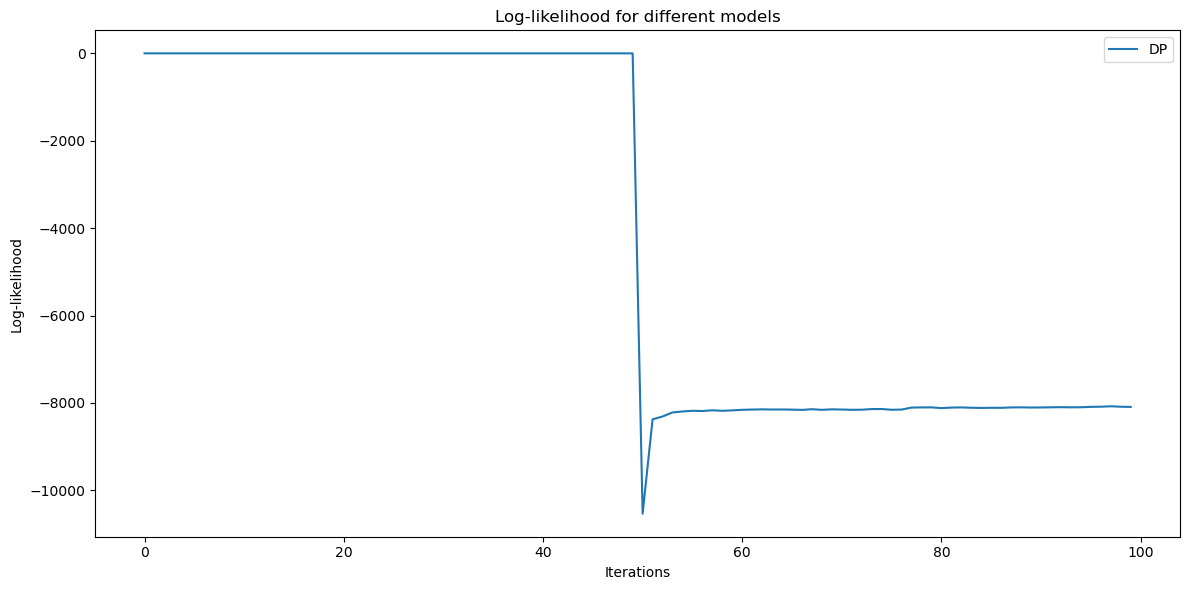

In [ ]:
llk_dp = model_dp.train_llk
# llk_py = model_py.train_llk
# llk_gn = model_gn.train_llk
# llk_esbm = model_esbm.train_llk

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(llk_dp[2::2], label='DP')
# ax.plot(llk_py[2::2], label='PY')
# ax.plot(llk_gn[2::2], label='GN')
# ax.plot(llk_esbm[2::2], label='ESBM')
ax.legend()


plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()

In [ ]:
mae_dp = model_dp.mae
# mae_py = model_py.mae
# mae_gn = model_gn.mae
# mae_esbm = model_esbm.mae

mse_dp = model_dp.mse
# mse_py = model_py.mse
# mse_gn = model_gn.mse
# mse_esbm = model_esbm.mse

waic_dp = model_dp.waic
# waic_py = model_py.waic
# waic_gn = model_gn.waic
# waic_esbm = model_esbm.waic

precision_dp = model_dp.precision_ranks
# precision_py = model_py.precision_ranks
# precision_gn = model_gn.precision_ranks
# precision_esbm = model_esbm.precision_ranks

recall_dp = model_dp.recall_ranks
# recall_py = model_py.recall_ranks
# recall_gn = model_gn.recall_ranks
# recall_esbm = model_esbm.recall_ranks

mae_dp, mse_dp, waic_dp, precision_dp, recall_dp

(51714.32110732231, 2674371011.663247, None, 0.1375, 0.07035408468121263)

In [ ]:
np.random.dirichlet([0.1, 0.1, 0.1], ).shape

(3,)

In [ ]:
# output_table = pd.DataFrame()
# output_table['MAE'] = [mae_dp, mae_py, mae_gn, mae_esbm]
# output_table['MSE'] = [mse_dp, mse_py, mse_gn, mse_esbm]
# output_table['WAIC'] = [waic_dp, waic_py, waic_gn, waic_esbm]
# output_table['Precision'] = [precision_dp, precision_py, precision_gn, precision_esbm]
# output_table['Recall'] = [recall_dp, recall_py, recall_gn, recall_esbm]

# output_table.index = ['DP', 'PY', 'GN', 'ESBM']
# output_table

In [ ]:
model_dp.n_clusters_items, model_dp.n_clusters_users

(1, 1)

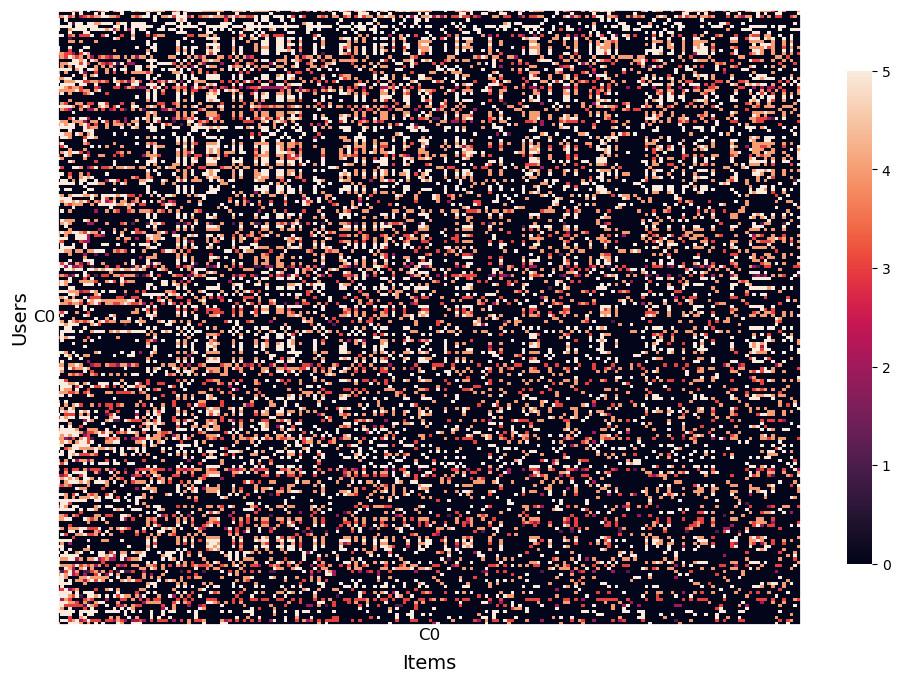

In [ ]:
plot_heatmap(model_dp, size=(12,8))#, plot_heatmap(model_py, size=(8,6)), plot_heatmap(model_gn, size=(8,6)), plot_heatmap(model_esbm, size=(8,6))

In [ ]:
_ = model_dp.gibbs_train(n_iters=10, verbose=0, warm_start=True)

starting log likelihood 102115.76010429197
end llk:  -8111.094919414359


In [ ]:
Y_val = y_val

Y_val_pairs = [(u,i) for u,i,_ in Y_val]
Y_val_users = [u for u,_,_ in Y_val]
Y_val_items = [i for _,i,_ in Y_val]
Y_val_ratings = [r for _,_,r in Y_val]

val_users_relevant = {}
val_users_unique = np.unique(Y_val_users)
model_list_out = []

for u, i in Y_val_pairs:
    if u not in val_users_relevant:
        val_users_relevant[u] = []
    val_users_relevant[u].append(i)

In [ ]:
model_dp.degree_param_users = 100
model_dp.degree_param_items = 100
model_dp.estimate_phi()
_ = model_dp.estimate_theta()

In [ ]:
model_dp.estimate_cluster_assignment_vi(burn_in=100, thinning=thinning)

model_ratings = model_dp.point_predict(Y_val_pairs, seed=42)
mae_model = mean_absolute_error(Y_val_ratings, model_ratings)
mse_model = mean_squared_error(Y_val_ratings, model_ratings)   

print('MAE:', mae_model)
print('MSE:', mse_model) 

ranks_model = model_dp.predict_k(val_users_unique, k=k)
    
precision_list_model = []   
recall_list_model = []
for j in range(len(val_users_unique)):
    precision_list_model.append(compute_precision(val_users_relevant[val_users_unique[j]], ranks_model[j]))
    recall_list_model.append(compute_recall(val_users_relevant[val_users_unique[j]], ranks_model[j]))
precision_model = sum(precision_list_model)/len(precision_list_model)
recall_model = sum(recall_list_model)/len(recall_list_model)
print('Precision:', precision_model)
print('Recall:', recall_model)

[ 5 18 10 11  5 47 10  5 10 10 10 13  5  4  9  5  2  5  5  5  1  1  2  1
  1] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 1 102
[ 5 18 10 11  5 47 10  5 10 10 10 13  5  4  9  5  2  5  5  5  1  1  2  1
  1] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 17 92
[ 5 18 10 11  5 47 10  5 10 10 10 13  5  4  9  5  2  5  5  5  1  1  2  1
  1] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 17 106
[ 5 18 10 11  5 47 10  5 10 10 10 13  5  4  9  5  2  5  5  5  1  1  2  1
  1] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 1 188
[ 5 18 10 11  5 47 10  5 10 10 10 13  5

(array([3.98e+03, 0.00e+00, 5.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        2.00e+00, 2.00e+00, 0.00e+00, 2.00e+00, 4.00e+00, 2.00e+00]),
 array([ 0.        ,  1.40790359,  2.81580717,  4.22371076,  5.63161435,
         7.03951793,  8.44742152,  9.8553251 , 11.26322869, 12.67113228,
        14.07903586, 15.48693945, 16.89484304, 18.30274662, 19.71065021,
        21.1185538 , 22.52645738, 23.93436097, 25.34226456, 26.75016814,
        28.15807173, 29.56597531, 30.9738789 , 32.38178249, 33.78968607,
        35.19758966, 36.60549325, 38.01339683, 39.42130042, 40.82920401,
        42.23710759]),
 <BarContainer object of 30 artists>)

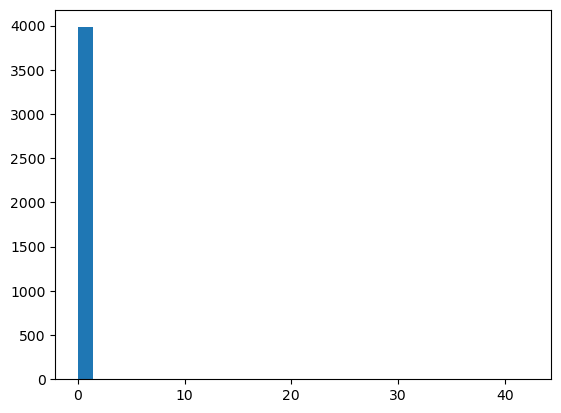

In [ ]:
plt.hist(model_ratings, bins=30)

In [ ]:
np.unique(np.round(model_ratings), return_counts=True)

(array([ 0.,  3.,  4., 31., 32., 33., 34., 36., 39., 40., 41., 42.]),
 array([3980,    3,    2,    1,    1,    1,    2,    2,    2,    4,    1,
           1]))

## Non dc model

In [ ]:
burn_in = 1000
thinning = 5
n_iters = 2000
k = 10

In [ ]:
params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5]}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['scheme_param'] = 0.5
params_dp['sigma'] = 0.5
params_dp['scheme_type'] = 'DP'


params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['scheme_param'] = 1
params_py['sigma'] = 0.7
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['gamma'] = 0.9
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 1
params_dp_cov['prior_b'] = 1
params_dp_cov['scheme_param'] = 0.5
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 1
params_gn_cov['prior_b'] = 1
params_gn_cov['gamma'] = 0.3
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 1
params_py_cov['prior_b'] = 1
params_py_cov['sigma'] = 0.7
params_py_cov['scheme_param'] = 0.5
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

model_list = [esbm, esbm, esbm, esbm, esbm, esbm]
params_list = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

In [ ]:
out_models = validate_models(Y_train, Y_val, model_list, params_list, n_iters=n_iters, burn_in=burn_in, k = k,
                                 thinning=thinning, model_names=model_names, true_users=true_users, true_items=true_items)


Model name: DP
Starting training for model DP
starting log likelihood -34232.09429665616
end llk:  -23781.1248436591
Starting waic computation DP
Starting prediction for model DP
Starting ranking for model DP

Model name: PY
Starting training for model PY
starting log likelihood -34232.09429665616
end llk:  -23826.251274828264
Starting waic computation PY
Starting prediction for model PY
Starting ranking for model PY

Model name: GN
Starting training for model GN
starting log likelihood -34232.09429665616
end llk:  -23839.11167367239
Starting waic computation GN
Starting prediction for model GN
Starting ranking for model GN

Model name: DP_cov
Starting training for model DP_cov
starting log likelihood -34232.09429665616
end llk:  -23820.938562184234
Starting waic computation DP_cov
Starting prediction for model DP_cov
Starting ranking for model DP_cov

Model name: PY_cov
Starting training for model PY_cov
starting log likelihood -34232.09429665616
end llk:  -23823.368440979342
Startin

In [ ]:
model_dp = out_models[0]
model_py = out_models[1]
model_gn = out_models[2]
model_dp_cov = out_models[3]
model_py_cov = out_models[4]
model_gn_cov = out_models[5]

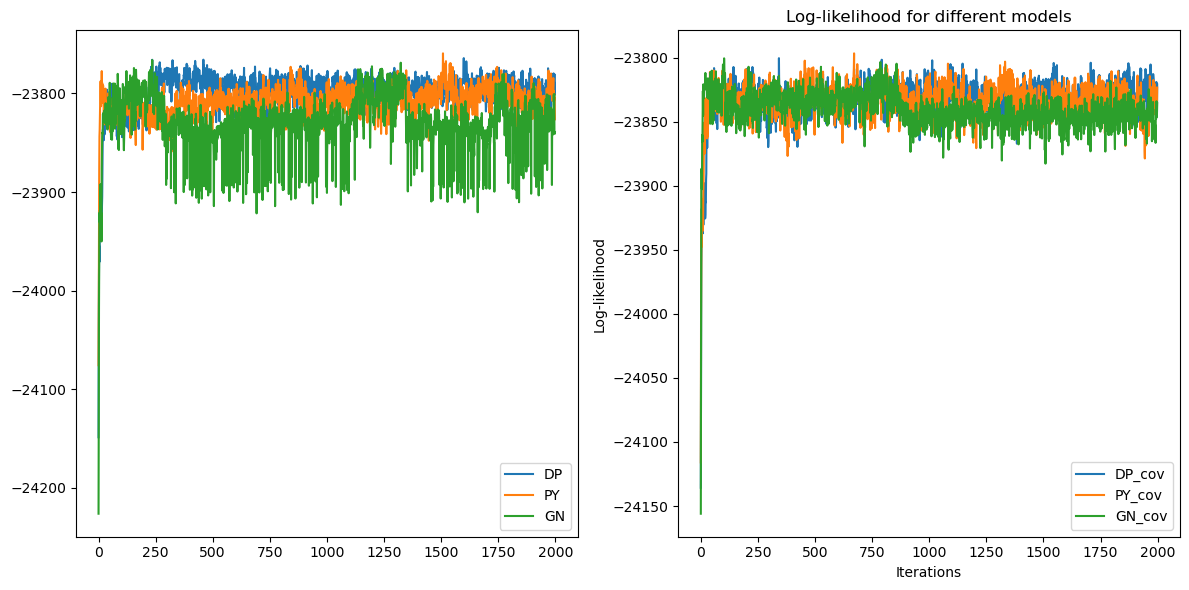

In [ ]:
llk_dp = out_models[0].train_llk
llk_py = out_models[1].train_llk
llk_gn = out_models[2].train_llk

llk_dp_cov = out_models[3].train_llk
llk_py_cov = out_models[4].train_llk
llk_gn_cov = out_models[5].train_llk

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(llk_dp[2:], label='DP')
ax[0].plot(llk_py[2:], label='PY')
ax[0].plot(llk_gn[2:], label='GN')
ax[0].legend()

ax[1].plot(llk_dp_cov[2:], label='DP_cov')
ax[1].plot(llk_py_cov[2:], label='PY_cov')
ax[1].plot(llk_gn_cov[2:], label='GN_cov')
ax[1].legend()

plt.title('Log-likelihood for different models')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')

plt.tight_layout()
plt.show()

In [ ]:
vi_users_dp = model_dp.vi_users
vi_items_dp = model_dp.vi_items
vi_users_py = model_py.vi_users
vi_items_py = model_py.vi_items
vi_users_gn = model_gn.vi_users
vi_items_gn = model_gn.vi_items

vi_users_dp_cov = model_dp_cov.vi_users
vi_items_dp_cov = model_dp_cov.vi_items
vi_users_py_cov = model_py_cov.vi_users
vi_items_py_cov = model_py_cov.vi_items
vi_users_gn_cov = model_gn_cov.vi_users
vi_items_gn_cov = model_gn_cov.vi_items

mae_dp = model_dp.mae
mae_py = model_py.mae
mae_gn = model_gn.mae

mae_dp_cov = model_dp_cov.mae
mae_py_cov = model_py_cov.mae
mae_gn_cov = model_gn_cov.mae

mse_dp = model_dp.mse
mse_py = model_py.mse
mse_gn = model_gn.mse

mse_dp_cov = model_dp_cov.mse
mse_py_cov = model_py_cov.mse
mse_gn_cov = model_gn_cov.mse

waic_dp = model_dp.waic
waic_py = model_py.waic
waic_gn = model_gn.waic

waic_dp_cov = model_dp_cov.waic
waic_py_cov = model_py_cov.waic
waic_gn_cov = model_gn_cov.waic

precision_dp = model_dp.precision_ranks
precision_py = model_py.precision_ranks
precision_gn = model_gn.precision_ranks

precision_dp_cov = model_dp_cov.precision_ranks
precision_py_cov = model_py_cov.precision_ranks
precision_gn_cov = model_gn_cov.precision_ranks

recall_dp = model_dp.recall_ranks
recall_py = model_py.recall_ranks
recall_gn = model_gn.recall_ranks

recall_dp_cov = model_dp_cov.recall_ranks
recall_py_cov = model_py_cov.recall_ranks
recall_gn_cov = model_gn_cov.recall_ranks

In [ ]:
output_table2 = pd.DataFrame()

output_table2['VI users'] = [vi_users_dp, vi_users_py, vi_users_gn, vi_users_dp_cov, vi_users_py_cov, vi_users_gn_cov]
output_table2['VI items'] = [vi_items_dp, vi_items_py, vi_items_gn, vi_items_dp_cov, vi_items_py_cov, vi_items_gn_cov]
output_table2['MAE'] = [mae_dp, mae_py, mae_gn, mae_dp_cov, mae_py_cov, mae_gn_cov]
output_table2['MSE'] = [mse_dp, mse_py, mse_gn, mse_dp_cov, mse_py_cov, mse_gn_cov]
output_table2['WAIC'] = [waic_dp, waic_py, waic_gn, waic_dp_cov, waic_py_cov, waic_gn_cov]
output_table2['Precision'] = [precision_dp, precision_py, precision_gn, precision_dp_cov, precision_py_cov, precision_gn_cov]
output_table2['Recall'] = [recall_dp, recall_py, recall_gn, recall_dp_cov, recall_py_cov, recall_gn_cov]

output_table2.index = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']
output_table2

In [ ]:
output_table2 = pd.DataFrame()

output_table2['VI users'] = [vi_users_dp, vi_users_py, vi_users_gn, vi_users_dp_cov, vi_users_py_cov, vi_users_gn_cov]
output_table2['VI items'] = [vi_items_dp, vi_items_py, vi_items_gn, vi_items_dp_cov, vi_items_py_cov, vi_items_gn_cov]
output_table2['MAE'] = [mae_dp, mae_py, mae_gn, mae_dp_cov, mae_py_cov, mae_gn_cov]
output_table2['MSE'] = [mse_dp, mse_py, mse_gn, mse_dp_cov, mse_py_cov, mse_gn_cov]
output_table2['WAIC'] = [waic_dp, waic_py, waic_gn, waic_dp_cov, waic_py_cov, waic_gn_cov]
output_table2['Precision'] = [precision_dp, precision_py, precision_gn, precision_dp_cov, precision_py_cov, precision_gn_cov]
output_table2['Recall'] = [recall_dp, recall_py, recall_gn, recall_dp_cov, recall_py_cov, recall_gn_cov]

output_table2.index = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']
output_table2.round(4)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,1.5272,1.3090,0.4830,0.5483,3244.6705,0.4420,0.1110
PY,1.5556,1.3747,0.4825,0.5467,3167.1810,0.4440,0.1118
GN,1.3281,1.2508,0.4799,0.5450,3139.7548,0.4360,0.1100
DP_cov,1.2870,1.2180,0.4795,0.5455,3126.0909,0.4395,0.1106
PY_cov,1.3130,1.2282,0.4823,0.5492,3093.5000,0.4415,0.1108
GN_cov,1.2722,1.2031,0.4799,0.5442,3115.9858,0.4460,0.1126


In [ ]:
output_table.round(4)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,0.1885,0.0000,0.4720,0.5295,3456.0706,0.4440,0.1115
PY,0.3635,0.0752,0.4736,0.5308,3372.7282,0.4400,0.1106
GN,0.1686,0.0752,0.4748,0.5310,3419.8139,0.4445,0.1116
DP_cov,0.0652,0.0000,0.4752,0.5315,3334.8288,0.4435,0.1114
PY_cov,0.0652,0.0000,0.4724,0.5294,3425.9722,0.4445,0.1116
GN_cov,0.2844,0.0000,0.4745,0.5319,3339.8332,0.4435,0.1114


from the next cell it is clear that the issue of flat esbm is that it tends to cluster based on degree 

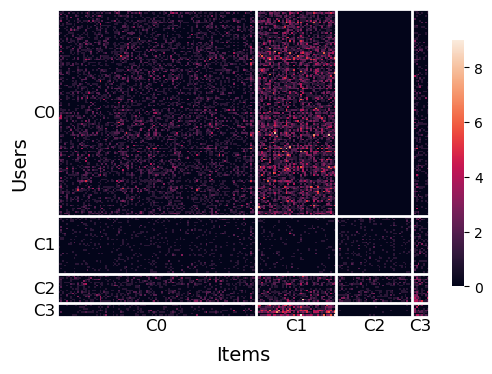

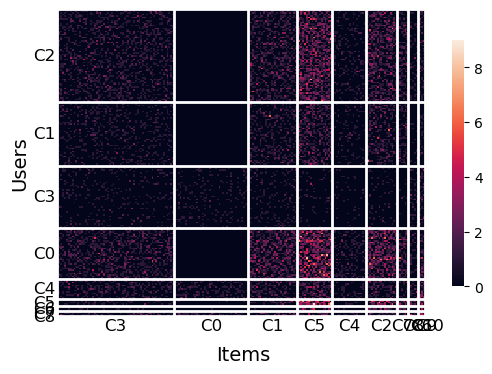

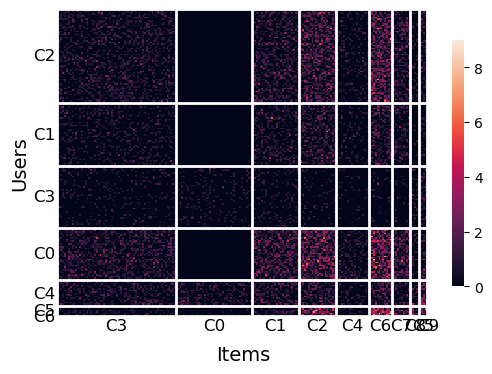

(None, None, None)

In [ ]:
plot_heatmap(model, size=(6,4)), plot_heatmap(model_py_cov, size=(6,4)), plot_heatmap(model_gn_cov, size=(6,4))

## other methods

In [ ]:
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
from sklearn.model_selection import GridSearchCV

spectral_bi = SpectralBiclustering(n_clusters=(5, 5), method='log', n_components=40, n_best=40)
spectral_bi.fit(Y_train)

SpectralBiclustering(method='log', n_best=40, n_clusters=(5, 5),
                     n_components=40)

In [ ]:
VI(model.user_clustering, relabel_clusters(spectral_bi.row_labels_)), VI(model.item_clustering, relabel_clusters(spectral_bi.column_labels_)) 

(array([1.73794648]), array([1.84691007]))

# past results

params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5]}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 3.5
params_dp['degree_param_users'] = 2
params_dp['degree_param_items'] = 4
params_dp['scheme_param'] = 0.135
params_dp['sigma'] = 0.329
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 3.5
params_py['degree_param_users'] = 1
params_py['degree_param_items'] = 15
params_py['scheme_param'] = 1.9
params_py['sigma'] = 0.7
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 3.5
params_gn['degree_param_users'] = 15
params_gn['degree_param_items'] = 10
params_gn['gamma'] = 0.9
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 0.7
params_dp_cov['prior_b'] = 3.5
params_dp_cov['degree_param_users'] = 16
params_dp_cov['degree_param_items'] = 11
params_dp_cov['scheme_param'] = 2
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 0.7
params_gn_cov['prior_b'] = 3.5
params_gn_cov['degree_param_users'] = 4
params_gn_cov['degree_param_items'] = 5
params_gn_cov['gamma'] = 0.3
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 0.7
params_py_cov['prior_b'] = 3.5
params_py_cov['degree_param_users'] = 4
params_py_cov['degree_param_items'] = 5
params_py_cov['sigma'] = 0.05
params_py_cov['scheme_param'] = 2
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

model_list = [dcesbm, dcesbm, dcesbm, dcesbm, dcesbm, dcesbm]
params_list = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

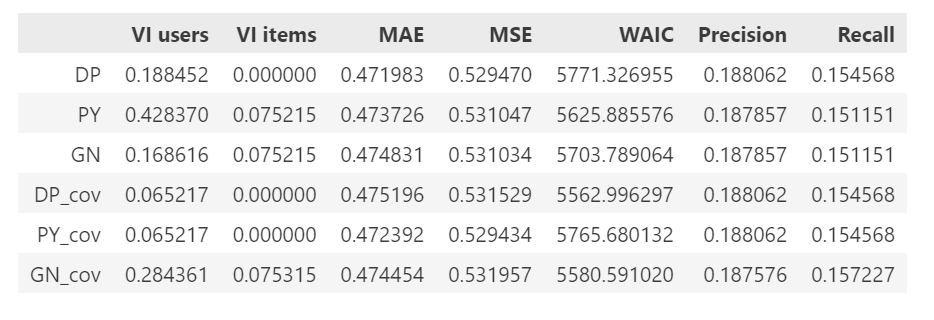
*data seed 1*

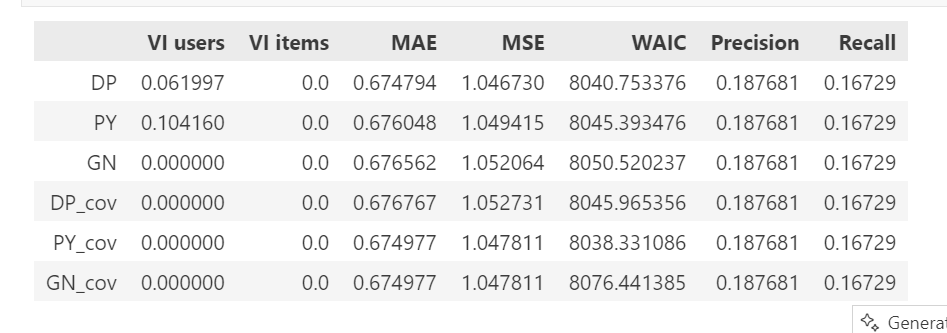
*data seed 42*